In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os,shutil
import random 
import cv2
import skimage
import matplotlib.pyplot as plt 
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [3]:
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,Dropout,Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
labels=['PNEUMONIA', 'NORMAL']
img_size=128

In [5]:
# data=[]
# for label in labels:
#     cl=labels.index(label)
#     path=os.path.join(train_dir,label)
#     print(path)
#     for img in os.listdir(path):
#         try:
#             img_arr=cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
#             resized_arr=cv2.resize(img_arr,(img_size,img_size))
#             data.append([resized_arr,cl])
#         except Exception as e:
#             print(e)
      

In [6]:
# d=[]
# img_p="/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1002_bacteria_2933.jpeg"
# img=cv2.imread(img_p)
# imgr=cv2.resize(img,(120,120))
# d.append([imgr,1])

In [7]:
# arrdata=np.array(data,dtype=object)

# print(arrdata)

In [8]:

def get_data(data_dir):
    data=[]
    for label in labels:
        path=os.path.join(data_dir, label)
        class_num=labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr=cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                resized_arr=cv2.resize(img_arr,(img_size,img_size))
                data.append([resized_arr,class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [9]:
train=get_data("/kaggle/input/chest-xray-pneumonia/chest_xray/train")
test=get_data("/kaggle/input/chest-xray-pneumonia/chest_xray/test")
val=get_data("/kaggle/input/chest-xray-pneumonia/chest_xray/val")

In [10]:
pneumonia=os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA")
pneumonia_dir="/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

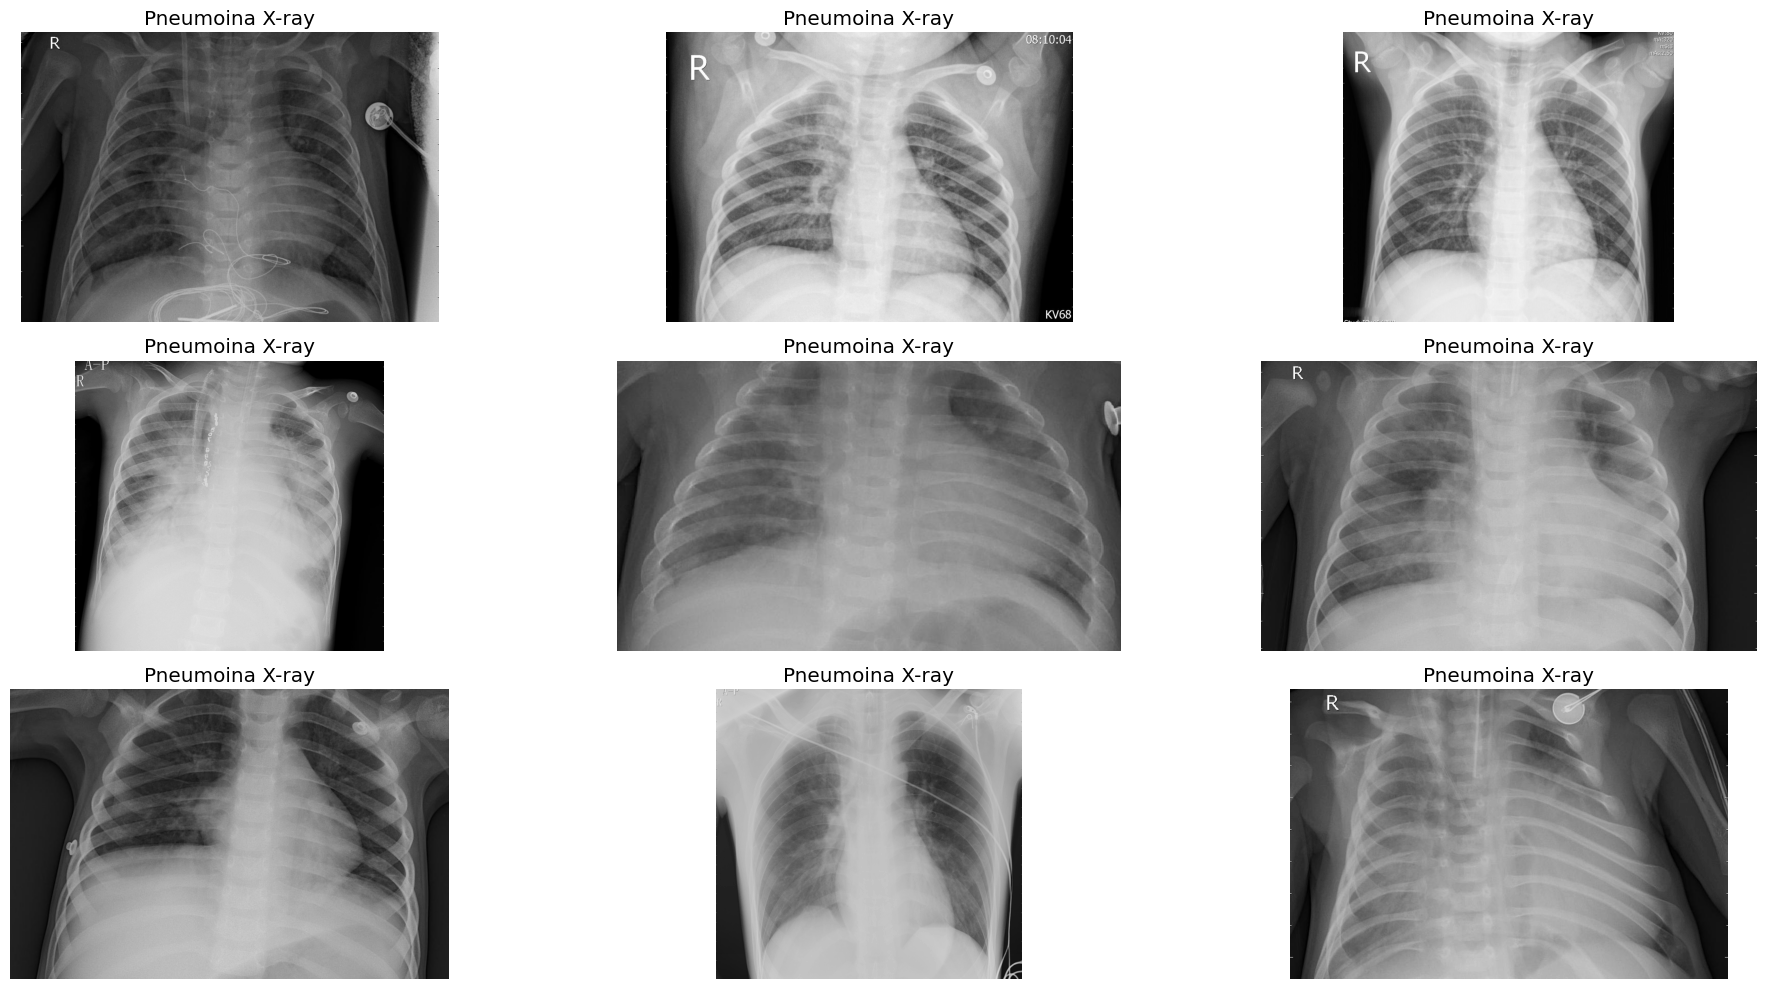

In [11]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3,i+1)
    img=plt.imread(os.path.join(pneumonia_dir,pneumonia[i]))
    plt.imshow(img,cmap='gray')
    plt.axis("off")
    plt.title("Pneumoina X-ray")
plt.tight_layout()

In [12]:
normal=os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL")
normal_dir="/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL"

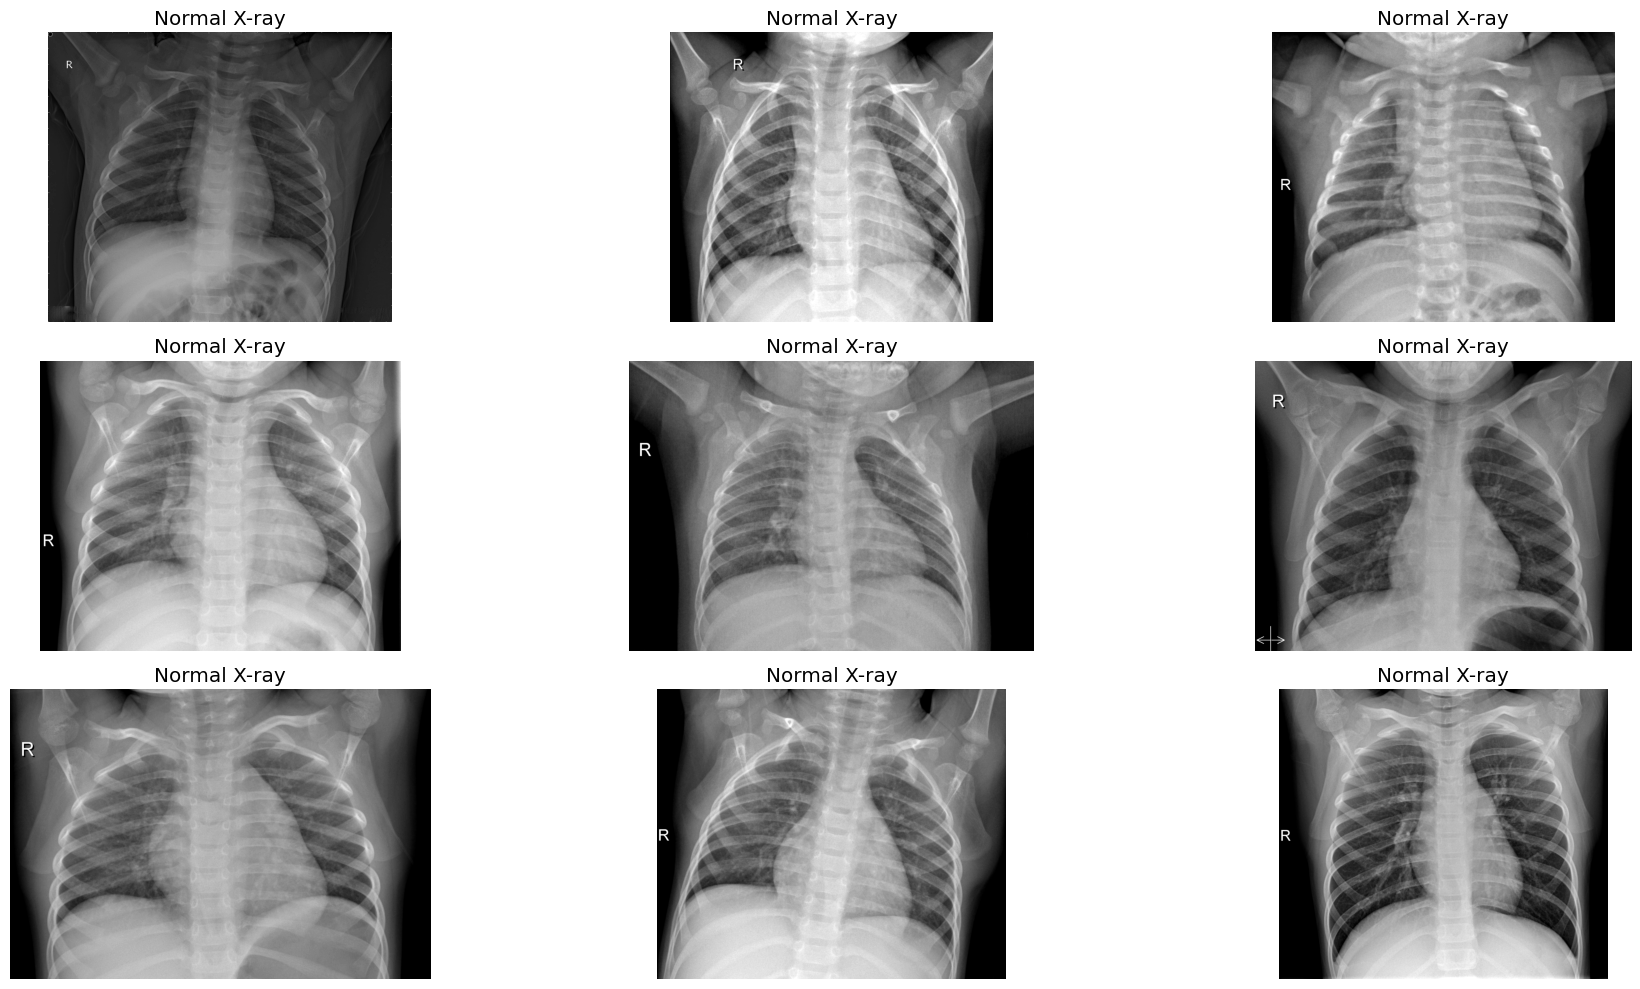

In [13]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3,i+1)
    img=plt.imread(os.path.join(normal_dir,normal[i]))
    plt.imshow(img,cmap='gray')
    plt.axis("off")
    plt.title("Normal X-ray")
plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


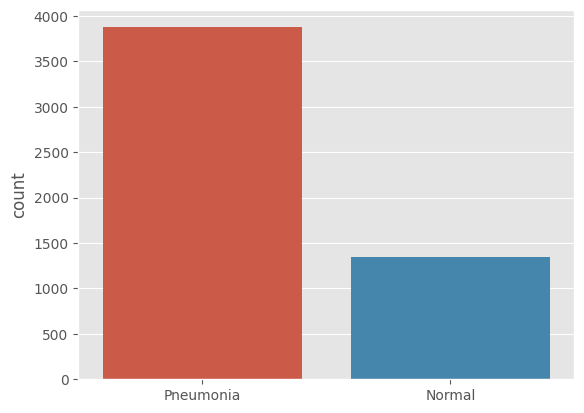

In [14]:
listx=[]
for i in train:
    if(i[1]==0):
        listx.append("Pneumonia")
    else:
        listx.append("Normal")
sns.countplot(x=listx)
plt.show()

In [15]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=0.4,
    vertical_flip=0.4,
    rotation_range=40,
    shear_range=0.2,
    width_shift_range=0.4,
    height_shift_range=0.4,
    fill_mode="nearest"
)
valid_datagen=ImageDataGenerator(
    rescale=1./255
)
test_datagen=ImageDataGenerator(
    rescale=1./255
)

In [16]:
trian_dir="/kaggle/input/chest-xray-pneumonia/chest_xray/train"
trian_data=train_datagen.flow_from_directory(
    trian_dir,
    batch_size=32,
    target_size=(128,128),
    class_mode='categorical',
    shuffle=True,
    seed=42,
    color_mode='rgb'
)


val_dir="/kaggle/input/chest-xray-pneumonia/chest_xray/val"
valid_data=valid_datagen.flow_from_directory(
    val_dir,
    batch_size=32,
    target_size=(128,128),
    class_mode='categorical',
    shuffle=True,
    seed=42,
    color_mode='rgb'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [17]:
class_labels=trian_data.class_indices

In [18]:
class_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [19]:
class_name={value:key for (key,value) in class_labels.items()}

In [20]:
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [21]:
#VGG19 CNN Architecture

**#VGG19 CNN Architecture**

In [22]:
base_model=VGG19(input_shape=(128,128,3),include_top=False,
     weights='imagenet')
for layer in base_model.layers:
    layer.trainable=False
x=base_model.output
flat=Flatten()(x)


class_1=Dense(4608,activation='relu')(flat)
dropout=Dropout(0.2)(class_1)
class_2=Dense(1152,activation='relu')(dropout)
output=Dense(2,activation='softmax')(class_2)
model_01=Model(base_model.inputs,output)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [23]:
model_01.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [24]:
filepath="model.keras"
es=EarlyStopping(monitor="val_loss",verbose=1,mode="min",patience=4)
cp=ModelCheckpoint(filepath,monitor="val_loss",save_best_only=True, save_weights_only=False,mode="auto",save_freq="epoch")
lrr=ReduceLROnPlateau(monitor="val_accuracy",patience=3,verbose=1,factor=0.5, min_lr=0.0001)


sgd=SGD(learning_rate=0.0001,decay=1e-6,momentum=0.0,nesterov=True)

model_01.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [25]:
history_01=model_01.fit(trian_data,
            steps_per_epoch=50,
            epochs=3,
            callbacks=[es,cp,lrr],
            validation_data=valid_data)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 436ms/step - accuracy: 0.6977 - loss: 0.5932 - val_accuracy: 0.5000 - val_loss: 0.7635 - learning_rate: 1.0000e-04
Epoch 2/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 384ms/step - accuracy: 0.7578 - loss: 0.5210 - val_accuracy: 0.5000 - val_loss: 0.7261 - learning_rate: 1.0000e-04
Epoch 3/3
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 351ms/step - accuracy: 0.7323 - loss: 0.5552 - val_accuracy: 0.5000 - val_loss: 0.7365 - learning_rate: 1.0000e-04


In [26]:
model_01.save("/kaggle/working/model_01.h5")

In [27]:
test_dir="/kaggle/input/chest-xray-pneumonia/chest_xray/test"
test_data=test_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=(128,128),
    class_mode='categorical',
    shuffle=True,
    seed=42,
    color_mode='rgb'
)

Found 624 images belonging to 2 classes.


In [28]:
model_01.load_weights("/kaggle/working/model_01.h5")
val_eval_01=model_01.evaluate(valid_data)
test_eval_01=model_01.evaluate(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.5000 - loss: 0.7365
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.6141 - loss: 0.6236


In [29]:
model_01.load_weights("/kaggle/working/model.keras")
val_eval_01=model_01.evaluate(valid_data)
test_eval_01=model_01.evaluate(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.5000 - loss: 0.7261
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.6158 - loss: 0.6217


In [30]:
print(f"Validation Accuracy: {val_eval_01[1]}" )
print(f"Validation Loss: {val_eval_01[0]}" )
print(f"Test Accuracy: {test_eval_01[1]}" )
print(f"Test Loss: {test_eval_01[0]}" )

Validation Accuracy: 0.5
Validation Loss: 0.7260816693305969
Test Accuracy: 0.625
Test Loss: 0.6152048707008362



# **Increamental unfreezing & fine tuning**


In [31]:
base_model=VGG19(include_top=False,input_shape=(128,128,3))
base_model_layer_name=[layer.name for layer in base_model.layers]


x=base_model.output
flat=Flatten()(x)


class_1=Dense(4608,activation='relu')(flat)
dropout=Dropout(0.2)(class_1)
class_2=Dense(1152,activation='relu')(dropout)
output=Dense(2,activation='sigmoid')(class_2)


model_02=Model(base_model.inputs,output)
model_02.load_weights("/kaggle/working/model_01.h5")

set_trainable=False
for layer in base_model.layers:
    if layer.name in ['block5_conv3','block5_conv4']:
        set_trainable=True
    if set_trainable:
        set_trainable=True
    else:
        set_trainable=False


In [32]:
model_02.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 63,089,602 (240.67 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
sgd=SGD(learning_rate=0.0001,decay=1e-6,momentum=0.0,nesterov=True)

model_02.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])

In [34]:
history_02=model_02.fit(trian_data,
            steps_per_epoch=10,
            epochs=2,
            callbacks=[es,cp,lrr],
            validation_data=valid_data)

Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 492ms/step - accuracy: 0.7916 - loss: 0.4828 - val_accuracy: 0.5000 - val_loss: 0.7276 - learning_rate: 1.0000e-04
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 507ms/step - accuracy: 0.7179 - loss: 0.5547 - val_accuracy: 0.5000 - val_loss: 0.7098 - learning_rate: 1.0000e-04


**Increamental unfreezing & fine tuning** 

In [35]:
model_02.save("/kaggle/working/model_02.h5")

In [36]:
model_02.load_weights("/kaggle/working/model_02.h5")
val_eval_02=model_02.evaluate(valid_data)
test_eval_02=model_02.evaluate(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.5000 - loss: 0.7098
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - accuracy: 0.6125 - loss: 0.6143


In [37]:
print(f"Validation Accuracy: {val_eval_02[1]}" )
print(f"Validation Loss: {val_eval_02[0]}" )
print(f"Test Accuracy: {test_eval_02[1]}" )
print(f"Test Loss: {test_eval_02[0]}" )

Validation Accuracy: 0.5
Validation Loss: 0.709762454032898
Test Accuracy: 0.629807710647583
Test Loss: 0.6015334725379944


# # **Unfreezing and fine tuning the entire network** 

In [38]:
base_model=VGG19(include_top=False,input_shape=(128,128,3))
 
x=base_model.output
flat=Flatten()(x)


class_1=Dense(4608,activation='relu')(flat)
dropout=Dropout(0.2)(class_1)
class_2=Dense(1152,activation='relu')(dropout)
output=Dense(2,activation='sigmoid')(class_2)


model_03=Model(base_model.inputs,output)
model_03.load_weights("/kaggle/working/model_01.h5")


print(model_03.summary())
 

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 63,089,602 (240.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [39]:
sgd=SGD(learning_rate=0.0001,decay=1e-6,momentum=0.0,nesterov=True)

model_03.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])

In [40]:
history_03=model_03.fit(trian_data,
            steps_per_epoch=100,
            epochs=35,
           
            validation_data=valid_data)

Epoch 1/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 43s 375ms/step - accuracy: 0.7441 - loss: 0.5213 - val_accuracy: 0.5625 - val_loss: 0.6825
Epoch 2/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - accuracy: 0.7689 - loss: 0.4673 - val_accuracy: 0.6250 - val_loss: 0.6125
Epoch 3/35


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 365ms/step - accuracy: 0.7675 - loss: 0.4561 - val_accuracy: 0.6875 - val_loss: 0.5771
Epoch 4/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.8099 - loss: 0.4048 - val_accuracy: 0.7500 - val_loss: 0.5243
Epoch 5/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 359ms/step - accuracy: 0.8109 - loss: 0.3882 - val_accuracy: 0.7500 - val_loss: 0.5188
Epoch 6/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 204ms/step - accuracy: 0.8366 - loss: 0.3561 - val_accuracy: 0.8125 - val_loss: 0.4797
Epoch 7/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 357ms/step - accuracy: 0.8437 - loss: 0.3440 - val_accuracy: 0.8125 - val_loss: 0.5097
Epoch 8/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - accuracy: 0.8554 - loss: 0.3141 - val_accuracy: 0.8125 - val_loss: 0.4778
Epoch 9/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 362ms/step - accuracy: 0.8869 - loss: 0.2799 - val_accuracy: 0.8125 - val_loss: 0.5113
Epoch 10/35
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - accuracy: 0.8680 - loss: 0.2920 - va

In [41]:
model_03.save("/kaggle/working/vgg_unfrozen.h5")

In [42]:
model_03.evaluate(test_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - accuracy: 0.8820 - loss: 0.3428


[0.3253049850463867, 0.8830128312110901]

In [43]:
model_03.load_weights("/kaggle/working/vgg_unfrozen.h5")
val_eval_0=model_03.evaluate(valid_data)
test_eval_02=model_03.evaluate(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8125 - loss: 0.3132
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - accuracy: 0.8859 - loss: 0.3156


In [44]:
print(f"Validation Accuracy: {val_eval_03[1]}" )
print(f"Validation Loss: {val_eval_03[0]}" )
print(f"Test Accuracy: {test_eval_03[1]}" )
print(f"Test Loss: {test_eval_03[0]}" )

NameError: name 'val_eval_03' is not defined

In [ ]:


predictions=model_03.predict(test_data)
print(predictions)

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
## funtion to load and procesing image
#load and processing
def getres(file):
    img = image.load_img(file, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model_03.predict(img_array)
    predicted_class = np.argmax(predictions)
    return predicted_class

In [ ]:
files="/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person102_bacteria_487.jpeg"
p=getres(files)
if p==0:
    print("Normal")
else:
    print("Affected probablity")